In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from scipy import stats
from common import load_data, pareto_rank
import os
import json

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import fpgrowth, fpmax

In [2]:
random_state = 1234
test_size = 0.2
pareto_cutoff = 0.4
(
    perf_matrix,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(system="nodejs", data_dir="../data", input_properties_type="tabular")

# Normalization is needed for the Pareto cutoff
# We can normalize before splitting, because
# we normalize per input and we also split per input.
# There is no data leakage.
normalized_metrics = (
    perf_matrix[["inputname"] + all_performances]
    .groupby("inputname", as_index=False)
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
cutoff_mask = (normalized_metrics <= pareto_cutoff).all(axis=1)

nmdf = perf_matrix[["inputname"] + all_performances].groupby("inputname", as_index=True).transform(lambda x: (x - x.min()) / (x.max() - x.min()))
perf_matrix = pd.merge(perf_matrix, nmdf, suffixes=("_raw", None), left_index=True, right_index=True)

all_perf_raw = [f"{p}_raw" for p in all_performances]
all_perf_norm = [f"{p}" for p in all_performances]

train_inp, test_inp = train_test_split(
    perf_matrix["inputname"].unique(),
    test_size=test_size,
    random_state=random_state,
)
train_perf = perf_matrix[perf_matrix.inputname.isin(train_inp)]
test_perf = perf_matrix[perf_matrix.inputname.isin(test_inp)]

all_performances

['ops']

In [3]:
perf_matrix

,--jitless,--experimental-wasm-modules,--experimental-vm-modules,--preserve-symlinks-main,--no-warnings,--node-memory-debug,ops_raw,inputname,configurationID,csize,#LOCs,variable_declarator,for_statement,if_statement,function_declaration,ops
38450,0,0,1,1,0,0,-268496.329534,0,0,773,34,10,1,1,1,0.227331
38451,1,0,1,1,1,0,-170201.941114,0,1,773,34,10,1,1,1,0.826062
38452,0,0,0,0,0,0,-305817.570706,0,2,773,34,10,1,1,1,0.000000
38453,1,0,1,0,1,0,-146520.851752,0,3,773,34,10,1,1,1,0.970308
38454,0,0,0,1,0,1,-264954.074186,0,4,773,34,10,1,1,1,0.248908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,1,0,1,0,0,0,-22573.288527,999,45,985,46,7,2,2,4,0.162586
3896,0,1,1,0,0,1,-21460.536745,999,46,985,46,7,2,2,4,0.437274
3897,0,1,0,0,0,1,-19373.638263,999,47,985,46,7,2,2,4,0.952434
3898,0,1,0,1,1,1,-23194.895527,999,48,985,46,7,2,2,4,0.009140


In [9]:
input_features

,csize,#LOCs,variable_declarator,for_statement,if_statement,function_declaration
inputname,,,,,,
0,773,34,10,1,1,1
1,773,34,10,1,1,1
10,2432,82,17,1,0,2
100,923,45,11,1,1,1
1000,985,46,7,2,2,4
...,...,...,...,...,...,...
995,985,46,7,2,2,4
996,985,46,7,2,2,4
997,985,46,7,2,2,4


In [12]:
config_features

,--jitless,--experimental-wasm-modules,--experimental-vm-modules,--preserve-symlinks-main,--no-warnings,--node-memory-debug
configurationID,,,,,,
0,0,0,1,1,0,0
1,1,0,1,1,1,0
2,0,0,0,0,0,0
3,1,0,1,0,1,0
4,0,0,0,1,0,1
5,1,0,0,1,0,1
6,1,1,0,0,1,0
7,0,1,1,1,1,1
8,0,0,1,1,1,0


In [14]:
performances = all_performances
icm = (
    train_perf[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: stats.rankdata(x, method="min")
)

# TODO Adjust pareto_rank with cutoff
# 1. Second version that ranks dominated configurations by their "dominators"
# 2. 
icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(pareto_rank)

# Calculate the Pareto ranks for the test data
icm_test = (
    test_perf[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_test["ranks"] = icm_test.groupby("inputname", group_keys=False).apply(pareto_rank)

icm

ops  ranks
inputname configurationID                 
1         0                0.311494     19
          1                0.979742     40
          2                0.247613     10
          3                0.797470     24
          4                0.109988      7
...                             ...    ...
999       45               0.162586     15
          46               0.437274     16
          47               0.952434     48
          48               0.009140      2
          49               0.788063     19

[77200 rows x 2 columns]

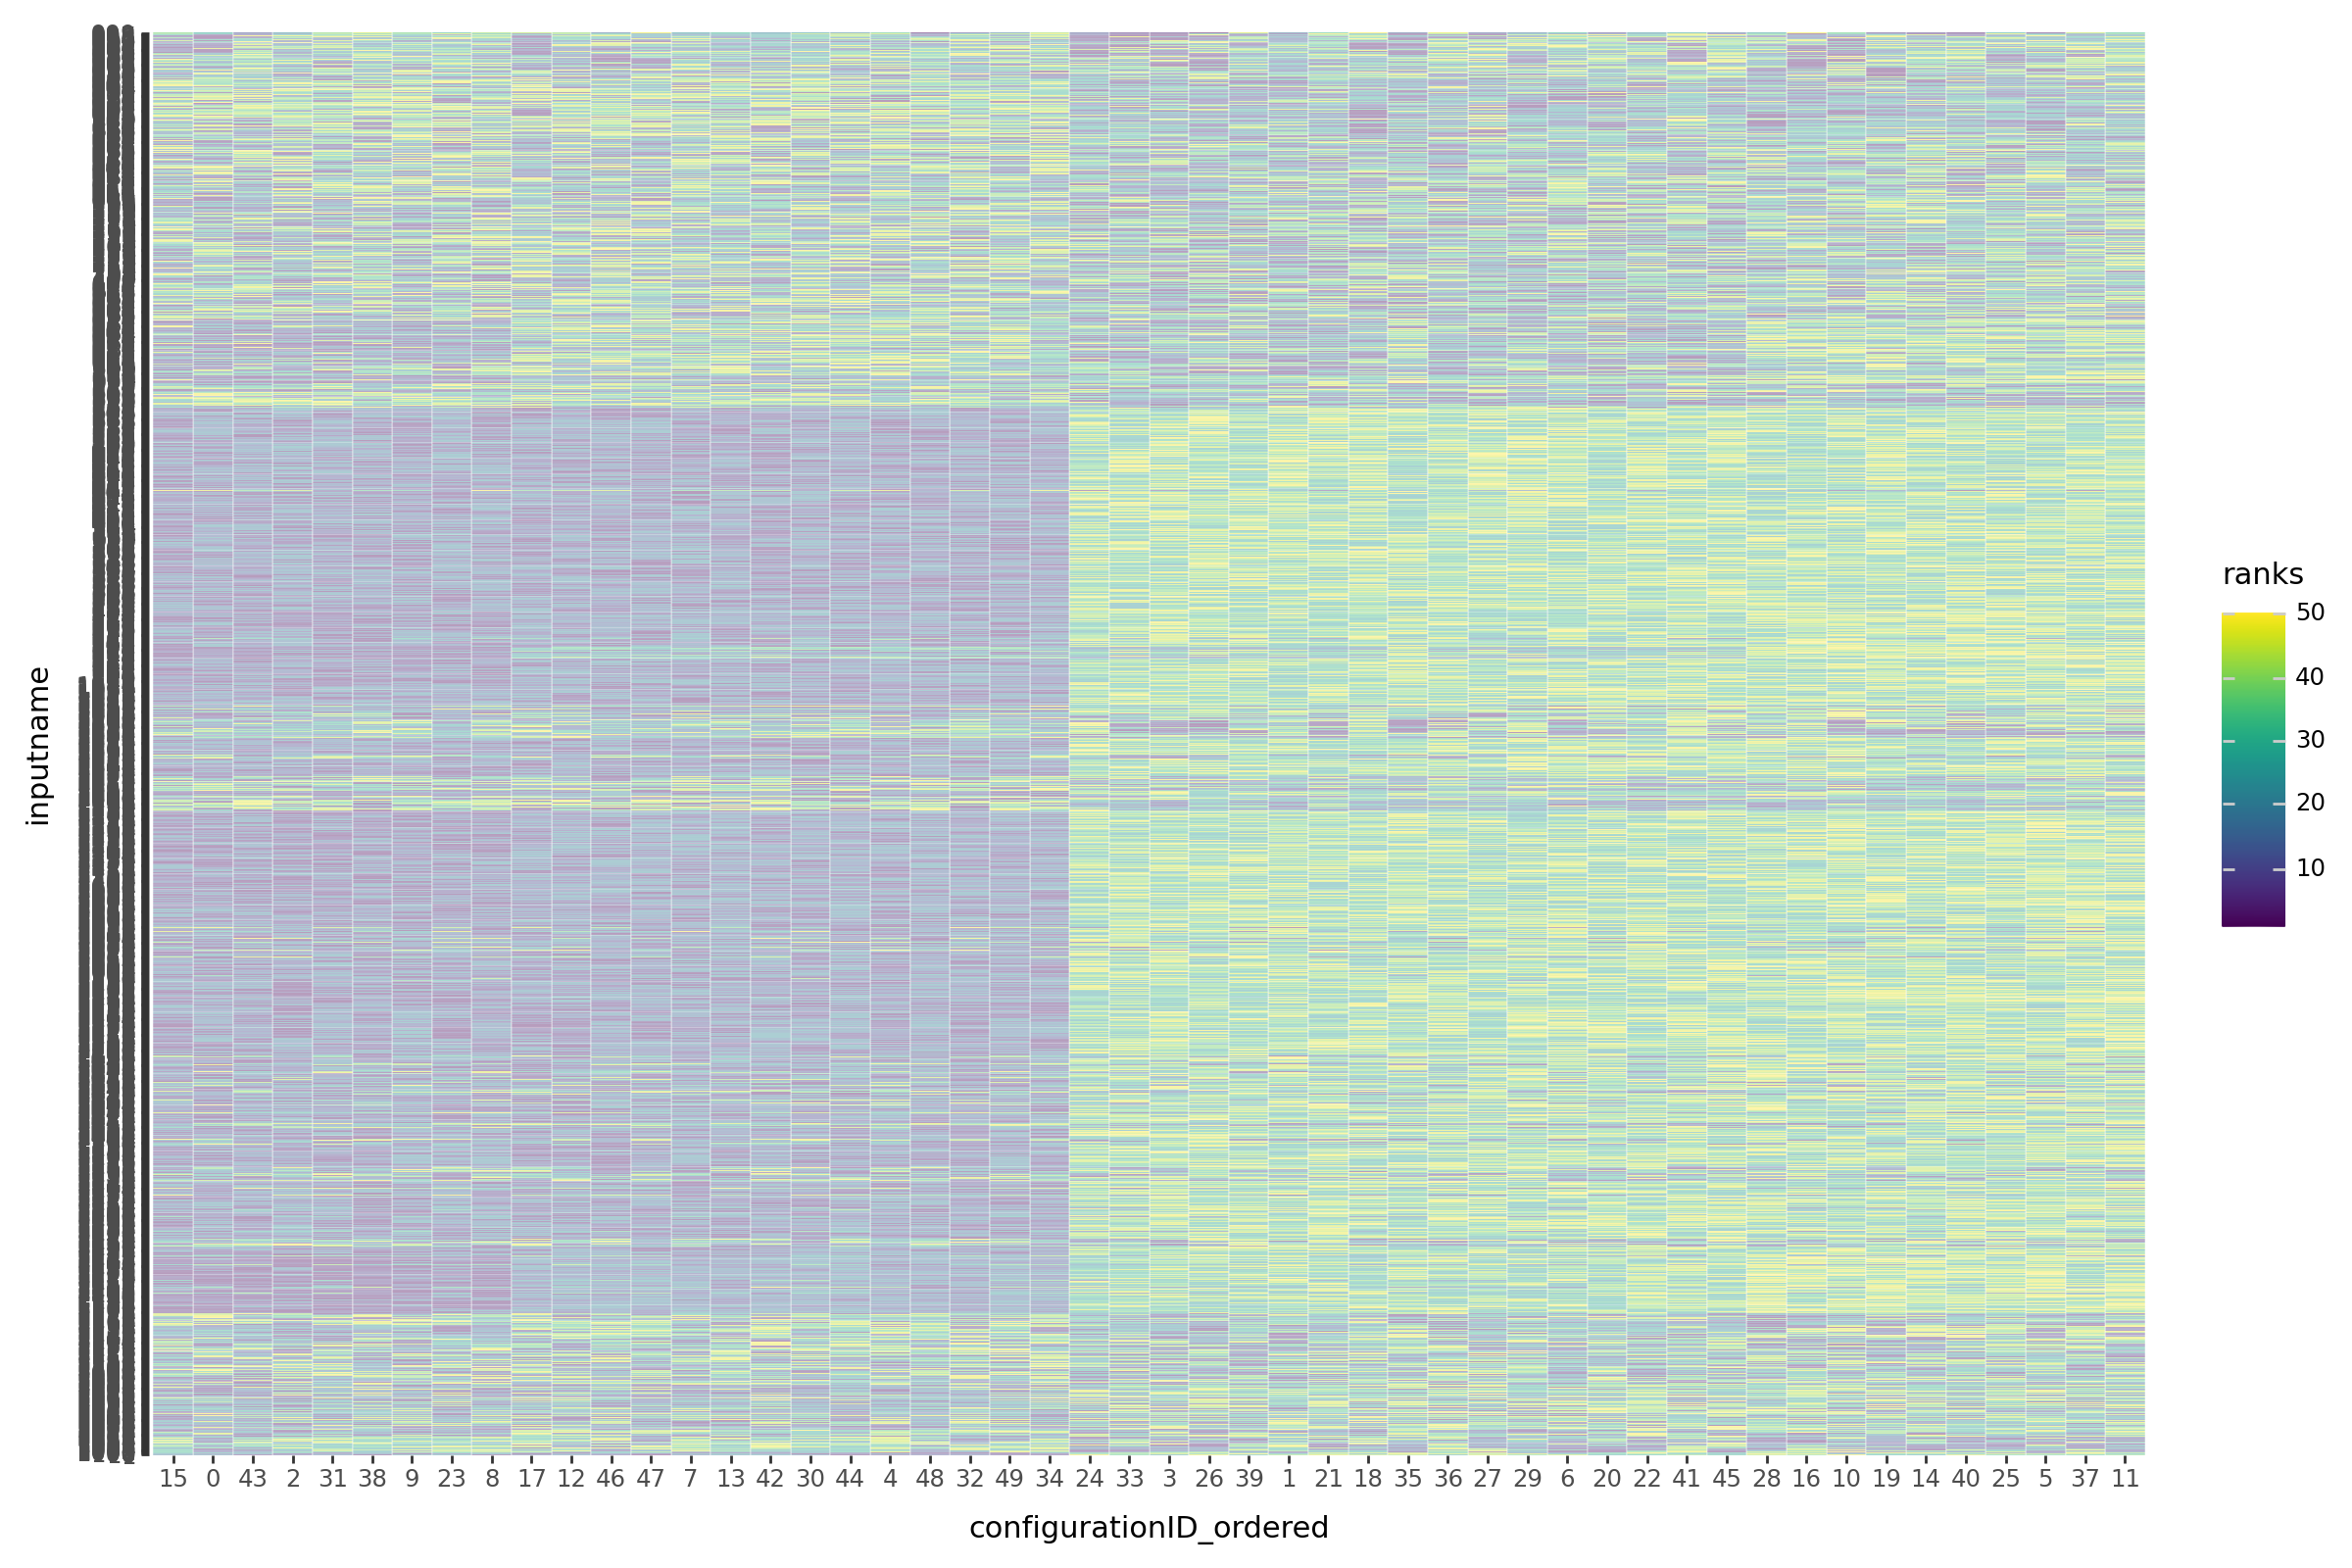

In [55]:
icr = icm.reset_index()
icr[["configurationID", "ranks"]].groupby("configurationID").agg(["mean", "std"])

mean_ranks = icr.groupby('configurationID')['ranks'].mean().sort_values()

# Create a new ordered categorical variable for configurationID
icr['configurationID_ordered'] = pd.Categorical(icr['configurationID'], categories=mean_ranks.index, ordered=True)

# Creating the plot with the ordered configurationID
(
    p9.ggplot(icr, p9.aes(x='configurationID_ordered', y='inputname', fill='ranks'))
    + p9.geom_tile(color='white', size=0.1)
    # + p9.scale_fill_cmap('plasma')
    + p9.scale_fill_cmap()
    + p9.theme(
        # axis_ticks=p9.element_blank(),
        # panel_background=p9.element_rect(fill="white"),
        figure_size=(12, 8)
    )
)

In [69]:
fd = pd.merge(perf_matrix, icm, how="inner")

In [73]:
fd[(fd.ranks < 20) & (fd.configurationID == 15)][["inputname"] + list(input_features.columns)].drop_duplicates()

,inputname,csize,#LOCs,variable_declarator,for_statement,if_statement,function_declaration
4699,1,773,34,10,1,1,1
78975,102,923,45,11,1,1,1
82143,1020,1381,73,11,4,2,3
97935,1025,316,18,4,1,0,1
101103,1026,316,18,4,1,0,1
...,...,...,...,...,...,...,...
6141714,99,923,45,11,1,1,1
6149604,991,985,46,7,2,2,4
6152772,992,985,46,7,2,2,4
6162228,995,985,46,7,2,2,4


In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
# from sklearn.en

X = fd[list(input_features.columns) + list(config_features.columns)].values
y = fd.ranks == 1

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('classifier', RandomForestClassifier(random_state=42))  # Decision Tree Classifier
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.50179471 0.50982191 0.49248442 0.49963248 0.50535538]
Mean cross-validation score: 0.5018177779252625


In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
# from sklearn.en

X = fd[list(input_features.columns) + list(config_features.columns)].values
y = fd.ranks == 1

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('classifier', HistGradientBoostingClassifier(random_state=42))  # Decision Tree Classifier
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.71661864 0.79751963 0.85080547 0.87135433 0.50600381]
Mean cross-validation score: 0.7484603749702599
